In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

def normalize_std(flux):
    flux = np.array(flux, dtype="float32")
    mean = flux.mean()
    std = flux.std()
    return (flux - mean) / (std + 1e-8)


latent_dim = 8

# ENCODER

T = N = 90*24*2
encoder_inputs = keras.Input(shape=(T, 1))  # 1D sequence, single channel
x = layers.LayerNormalization(axis=1)(encoder_inputs)  # normalize along the sequence (per sample)
x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

# DECODER
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense((T // 4) * 64, activation="relu")(latent_inputs)  # match downsampling in encoder
x = layers.Reshape((T // 4, 64))(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv1D(1, 3, activation="linear", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()


2025-10-05 12:23:31.574131: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-05 12:23:31.574674: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-05 12:23:31.654145: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-05 12:23:32.802902: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4320, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2160, 32)  │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1080, 64)  │      6,208 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 69120)     │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  8,847,488 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      1,032 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      1,032 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 8)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,855,888 (33.78 MB)

 Trainable params: 8,855,888 (33.78 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 69120)          │       622,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1080, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 2160, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2160, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 4320, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 4320, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 4320, 1)        │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,705 (2.44 MB)

 Trainable params: 640,705 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
# --- VAE Model ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        noisy, clean = data  # unpack tuple (noisy input, clean target)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(noisy)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(keras.losses.mean_squared_error(clean, reconstruction), axis=1)
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [3]:
# --- Load noise dataset ---
import numpy as np
with np.load("star_noise_cohort.npz") as npz:
    data = npz["data"]  # shape (NUM, N)
    n_samples = int(npz["n_samples"])
    fs = float(npz["fs"])

# Add transits
def add_transit_batch(data, fs, depth=0.01, duration=50, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    data_with_transits = []
    for signal in data:
        n_samples = len(signal)
        t = np.arange(n_samples) / fs
        t0 = rng.uniform(0.2, 0.8) * t[-1]
        dur = duration / fs
        mask = np.abs(t - t0) < (dur / 2)
        signal_transit = signal.copy()
        signal_transit[mask] -= depth
        data_with_transits.append(signal_transit)
    return np.array(data_with_transits)

data_with_transits = add_transit_batch(data, fs)

# Reshape for CNN (num_samples, length, channels)
X_clean = data[..., np.newaxis].astype("float32")
X_noisy = data_with_transits[..., np.newaxis].astype("float32")


In [4]:
print(len(data[0]))
print("51184")

4320
51184


In [35]:
import matplotlib.pyplot as plt
# --- Helper: plot reconstructions ---
def plot_reconstructions(model, noisy, clean, n=5):
    idxs = np.random.choice(len(noisy), n, replace=False)
    reconstructed = model.decoder(model.encoder(noisy[idxs])[2]).numpy()
    plt.figure(figsize=(10, 2 * n))
    for i, idx in enumerate(idxs):
        plt.subplot(n, 1, i + 1)
        plt.plot(noisy[idx, :, 0], label="Noisy (with transit)", color="red")
        plt.plot(clean[idx, :, 0], label="Target (clean star noise)", color="blue", alpha=0.5)
        plt.plot(reconstructed[i, :, 0], label="Reconstructed", color="black", alpha=0.5)
        plt.legend()
    plt.tight_layout()
    plt.show()

# --- Load noise dataset ---
with np.load("star_noise_cohort.npz") as npz:
    data = npz["data"]  # shape (NUM, N)
    n_samples = int(npz["n_samples"])
    fs = float(npz["fs"])

t = np.arange(N)
true_period = 320
true_dur = 20
alpha = 0.2
from noise_generator import boxtransit
template_true = boxtransit(t, period=true_period, dur=true_dur, t0=0, alpha=alpha)

print(data.shape)

(1000, 4320)


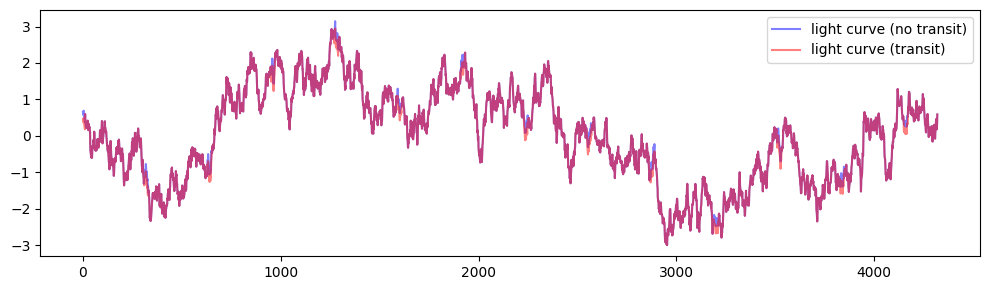

In [6]:

# lc += planet
# highlight transit in time series like in noise_sim
planet_mask = template_true != 0
transited_planet = data[0] + template_true

plt.figure(figsize=(10, 3))
plt.plot(np.arange(N), data[0], color='blue', alpha=0.5, label='light curve (no transit)')
plt.plot(np.arange(N), transited_planet, color='red', alpha=0.5, label='light curve (transit)')

#plt.scatter(np.arange(N)[planet_mask], transited_planet[planet_mask], color='red', s=6, zorder=3, label='Planet (in-transit)')
plt.legend()
plt.tight_layout()
plt.show()

# test to see transits effect

In [7]:
# Add transits
def add_transit_batch(data, fs, depth=0.01, duration=50, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    data_with_transits = []
    for signal in data:
        t = np.arange(N)
        true_period = 320
        true_dur = 20
        alpha = 0.25 * np.random.randn() + 0.5 # should be range 0.25 to 0.75
        from noise_generator import boxtransit
        transit = boxtransit(t, period=true_period, dur=true_dur, t0=0, alpha=alpha)
        signal_transit = signal.copy()
        signal_transit += transit
        data_with_transits.append(signal_transit)
    return np.array(data_with_transits)

data_with_transits = add_transit_batch(data, fs)

# Reshape for CNN (num_samples, length, channels)
X_clean = data[..., np.newaxis].astype("float32")
X_noisy = data_with_transits[..., np.newaxis].astype("float32")

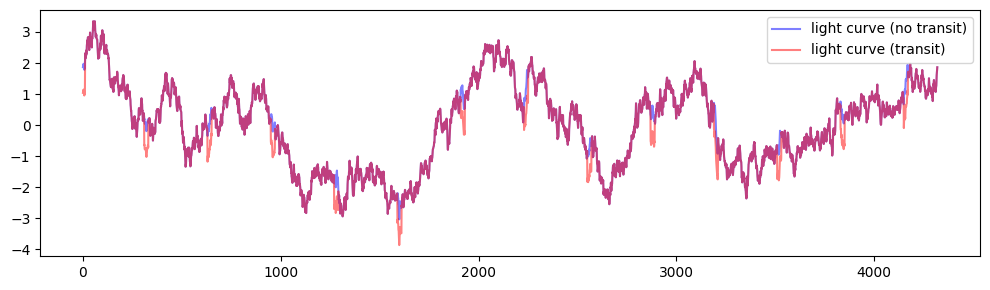

In [8]:
# look at some transits

plt.figure(figsize=(10, 3))
plt.plot(np.arange(N), X_clean[10], color='blue', alpha=0.5, label='light curve (no transit)')
plt.plot(np.arange(N), X_noisy[10], color='red', alpha=0.5, label='light curve (transit)')

#plt.scatter(np.arange(N)[planet_mask], transited_planet[planet_mask], color='red', s=6, zorder=3, label='Planet (in-transit)')
plt.legend()
plt.tight_layout()
plt.show()

# test to see transits effect

In [16]:
# --- Train ---
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")

history = vae.fit(
    X_noisy, X_clean,  # input noisy → target clean
    epochs=250,
    batch_size=128,
)

Epoch 1/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - kl_loss: 30.1055 - loss: 3306.4827 - reconstruction_loss: 3276.3770
Epoch 2/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - kl_loss: 24.6590 - loss: 2130.1614 - reconstruction_loss: 2105.5024
Epoch 3/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - kl_loss: 33.5296 - loss: 1469.4209 - reconstruction_loss: 1435.8914
Epoch 4/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - kl_loss: 36.3701 - loss: 1193.3734 - reconstruction_loss: 1157.0033
Epoch 5/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - kl_loss: 40.3153 - loss: 997.3095 - reconstruction_loss: 956.9942 
Epoch 6/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - kl_loss: 43.7441 - loss: 870.1477 - reconstruction_loss: 826.4036
Epoch 7/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - kl_loss: 45.3642 - loss: 781.7861 - reconstruction_loss: 736.4219
Epoch 8/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - kl_loss: 46.0048 - loss: 724.1937 - reconstruction_loss: 678.1888
Epoch 9/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s

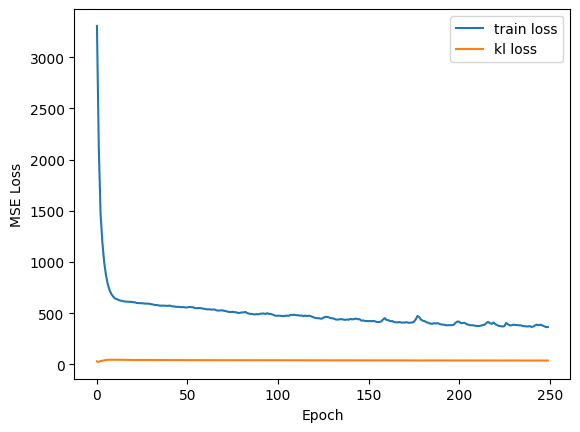

In [17]:
# Plot loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['kl_loss'], label='kl loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

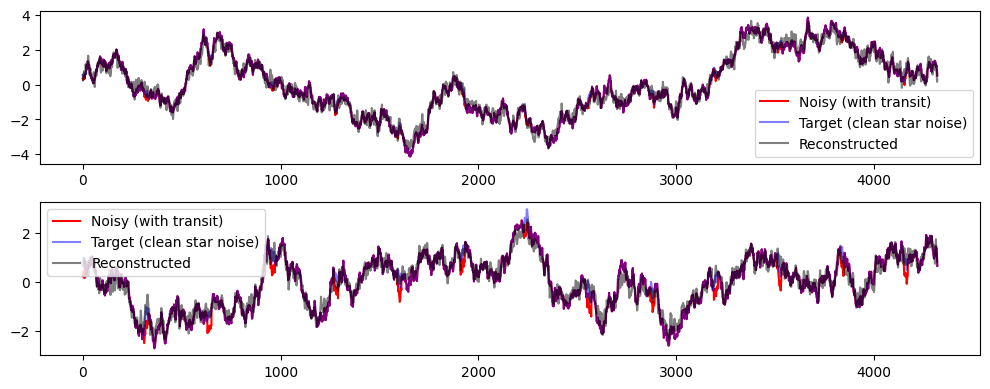

In [36]:
plot_reconstructions(vae, X_noisy, X_clean, n=2)

In [19]:
import pickle
with open("TESS_data/processed_data/229644321_normalized.p", "rb") as f:   # "rb" = read in binary mode
    lc_norm_data = pickle.load(f)
cadence = lc_norm_data["cadence"]
flux = lc_norm_data["processed_flux"]

In [20]:
def downsample_to_T(flux, T):
    flux = np.array(flux, dtype="float32")
    N = len(flux)
    
    # Compute the size of each bin
    bin_size = N / T  # may not be an integer
    
    downsampled = np.zeros(T, dtype="float32")
    
    for i in range(T):
        # find start and end indices in original array
        start = int(np.floor(i * bin_size))
        end = int(np.floor((i + 1) * bin_size))
        if end <= start:
            end = start + 1  # make sure at least one element
        downsampled[i] = flux[start:end].mean()
    
    return downsampled.astype("float32").reshape(1, T, 1) - 1

In [ ]:
def remove_transit(model, noisy):
    # Get mean and std along the sequence for this sample
    mean = noisy.mean(axis=1, keepdims=True)
    std = noisy.std(axis=1, keepdims=True) + 1e-6
    
    # Reconstruct
    reconstructed_norm = model.decoder(model.encoder(noisy)[2]).numpy()
    recon_mean = reconstructed_norm.mean(axis=1, keepdims=True)
    recon_std = reconstructed_norm.std(axis=1, keepdims=True)
    reconstructed_norm = (reconstructed_norm / recon_std) - recon_mean
    
    # Denormalize
    reconstructed = (reconstructed_norm) * std + mean

    plt.plot(noisy[0, :, 0], label="Input Star Curve (with transit)", alpha=0.6)
    plt.plot(reconstructed[0, :, 0], label="Reconstructed (without transit)", alpha=0.8)

    plt.legend()
    plt.tight_layout()
    plt.show()


65331


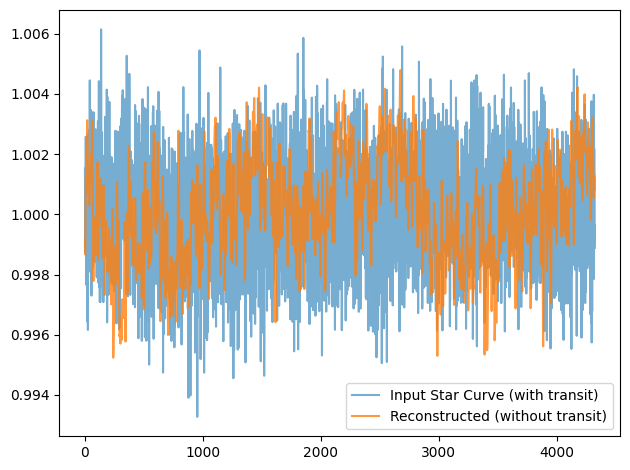

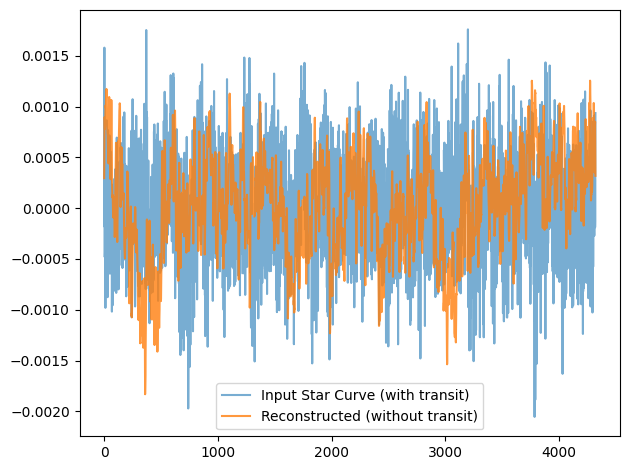

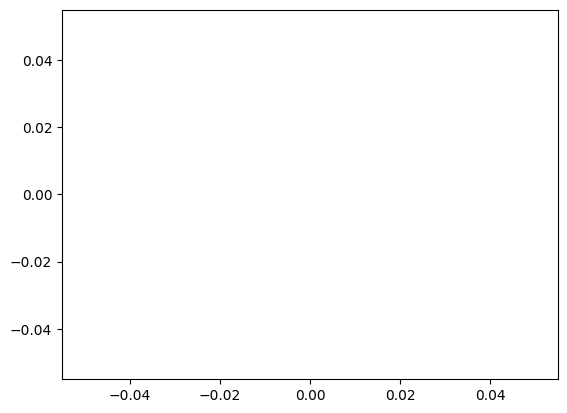

In [22]:
flux = np.array(flux, dtype="float32")
print(len(flux))
start = np.random.randint(0, len(flux) - T)
flux_segment = flux[start:start+T] # normalize around 0 instead of around 1

flux_segment = flux_segment.astype("float32").reshape(1, T, 1)
sampled_segment = downsample_to_T(flux, T)
remove_transit(vae, flux_segment)
remove_transit(vae, sampled_segment)
